## Argo Test

In this notebook I'm attempting to replicate some of the glider results with Argo data in the region of 30E-40E and 50S-55S.

In [188]:
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()
import scipy.ndimage as filter
filter.gaussian_filter1d

<function scipy.ndimage._filters.gaussian_filter1d(input, sigma, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)>

## Load Points, Make Profiles, Remove Profiles with Sampling Frequency Less Than 2m

In [174]:
ds = argo_loader.region([30,40,-55,-50, 200,1500]).to_xarray()

In [175]:
ds_prof=ds.argo.point2profile()

(array([15.,  7.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  8.]),
 array([  9.5     ,  18.609997,  27.719995,  36.829994,  45.93999 ,
         55.049988,  64.15999 ,  73.26998 ,  82.37998 ,  91.489975,
        100.599976], dtype=float32),
 <BarContainer object of 10 artists>)

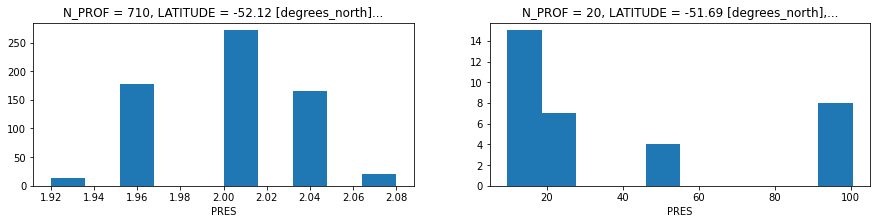

In [176]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
prof_1=ds_prof.PRES.isel(N_PROF=-10).diff('N_LEVELS')
prof_1.plot.hist()

plt.subplot(1,2,2)
prof_2=ds_prof.PRES.isel(N_PROF=1).diff('N_LEVELS')
prof_2.plot.hist()

(array([  0., 416.,   0.,  66.,   0.,   0., 875., 106.,   2.,  16.,   0.,
          2.,  13.]),
 array([ 0.        ,  1.53846154,  3.07692308,  4.61538462,  6.15384615,
         7.69230769,  9.23076923, 10.76923077, 12.30769231, 13.84615385,
        15.38461538, 16.92307692, 18.46153846, 20.        ]),
 <BarContainer object of 13 artists>)

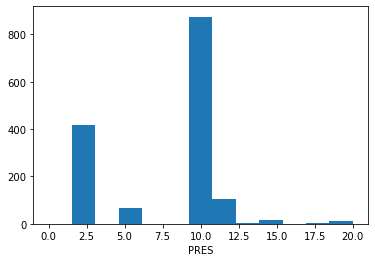

In [177]:
median_dp=ds_prof.PRES.where(ds_prof.PRES<1000).diff('N_LEVELS').median('N_LEVELS')
median_dp.plot.hist(bins=np.linspace(0,20,14))

In [183]:
ind_2m=median_dp.where(median_dp<3.,drop=True).N_PROF
ds_sel=ds_prof.sel(N_PROF=ind_2m)
ds_interp=ds_sel.argo.interp_std_levels(np.arange(200,900,2))
ds_interp=ds_interp.sortby(ds_interp.N_PROF)

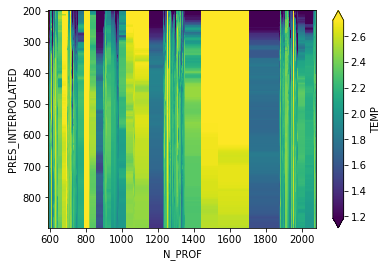

In [185]:
ds_interp.TEMP.plot(y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

## Filtering Analysis

In [215]:
CT=ds_interp.TEMP

first=10
last=300
step=5
quant=int((last-first)/step)+1

temp=np.zeros((CT.N_PROF.shape[0],CT.PRES_INTERPOLATED.shape[0],quant))
filter_scales=np.zeros((quant))

for n,sig in enumerate(range(first,last+1,step)):
    sigma=sig/4/np.sqrt(12)
    temp[:,:,n]=filter.gaussian_filter1d(CT,sigma=sigma,mode='nearest')
    filter_scales[n]=sig
CT_filt=xr.DataArray(temp, dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],coords={'N_PROF':CT.N_PROF,'PRES_INTERPOLATED':CT.PRES_INTERPOLATED,'FILT_SCALE':filter_scales})

In [216]:
CT_filt.FILT_SCALE.shape

(59,)

IndexError: index 60 is out of bounds for axis 2 with size 59

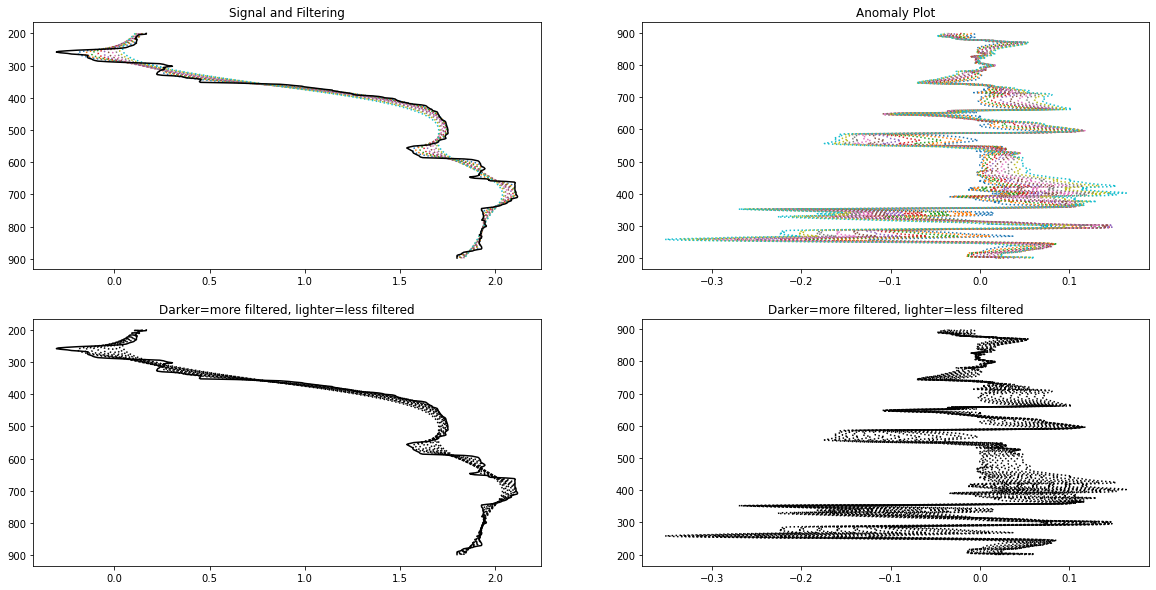

In [229]:
plt.figure(figsize=(20,10))

color=np.arange(0.01,1.01,step=1/quant)
color=np.flip(color,0)

plt.subplot(2,2,1)
prof=CT.isel(N_PROF=25)
plt.plot(prof,prof.PRES_INTERPOLATED,color='black',zorder=100)
plt.gca().invert_yaxis()
plt.title("Signal and Filtering")

plt.subplot(2,2,2)
plt.title("Anomaly Plot")

plt.subplot(2,2,3)
prof=CT.isel(N_PROF=25)
plt.plot(prof,prof.PRES_INTERPOLATED,color='black',zorder=100)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

plt.subplot(2,2,4)
plt.title("Darker=more filtered, lighter=less filtered")

for sig in range(first, last+1, step):
    filt=CT_filt.isel(N_PROF=25,FILT_SCALE=sig)
    anom=prof-filt
    
    plt.subplot(2,2,1)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,2)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,3)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))
    
    plt.subplot(2,2,4)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))